# Introduction
This notebook buils a workflow to predict metastatic spread using histopathology images from PatchCamelyon. When it comes to histopathology data, there are two approaches, classification and segmentation, i.e., classifying images versus determining where in the image something like cancer cells are located. Here we will focus on classification only.

Dataset used:
https://www.kaggle.com/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon?select=Labels

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962
[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585


In [ ]:
#| eval: false
# Download Dataset
!curl -L -o ./data/metastatic-tissue-classification-patchcamelyon.zip\
  https://www.kaggle.com/api/v1/datasets/download/andrewmvd/metastatic-tissue-classification-patchcamelyon

In [ ]:
#| eval: false
!unzip -l ./data/metastatic-tissue-classification-patchcamelyon.zip

In [ ]:
!unzip ./data/metastatic-tissue-classification-patchcamelyon.zip -d ./data/

In [ ]:
!rm ./data/metastatic-tissue-classification-patchcamelyon.zip

This is what the data folder structure looks like:

In [5]:
!tree ./data

./data
├── Labels
│   └── Labels
│       ├── camelyonpatch_level_2_split_test_y.h5
│       ├── camelyonpatch_level_2_split_train_y.h5
│       └── camelyonpatch_level_2_split_valid_y.h5
├── Metadata
│   └── Metadata
│       ├── test_metadata.csv
│       ├── train_metadata.csv
│       └── valid_metadata.csv
├── camelyonpatch_level_2_split_train_mask
│   └── camelyonpatch_level_2_split_train_mask.h5
└── pcam
    ├── test_split.h5
    ├── training_split.h5
    └── validation_split.h5

7 directories, 10 files


Because we are not doing segmentation, we do not need `camelyonpatch_level_2_split_train_mask`
Differently from what we saw in the course, here the data is structured in a `HDF5` files, i.e. `Hierarchical Data Format version 5`. This format is used for large amounts of data. In this way, images are stored in `pcam/` while labels are in `Labels/Labels
To read these `HDF5` files we need `h5py` library. They are already represented as arrays.

In [50]:
#| eval: false
!uv add h5py "numpy<2" pandas matplotlib "torch==2.2.2" "torchvision==0.17.2" scikit-learn torchsummary seaborn onnx "onnxruntime==1.22.1"

Resolved 55 packages in 12ms
Audited 38 packages in 2ms


# Exploratory Data Analysis
## Inspect some images
Let's start by having a look at some of the images.
The data is split info `x files` and `y files`, with the `x` containing the data and the `y` containing the labels.
The images are 96x96 px in size, and a positive label means that the central area of 32x32 px contains at least one pixel with tumour tissue.

Shape: (5, 96, 96, 3)
Shape: (5, 1, 1, 1)


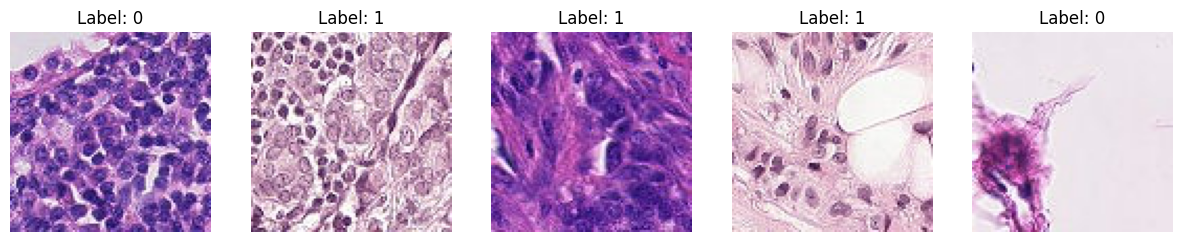

In [7]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(123)

# open the file and take the first 5 images
with h5py.File('./data/pcam/training_split.h5', 'r') as f_in:
    X_train = f_in['x'] 
    
    first_five_images = X_train[0:5] 
    print(f"Shape: {first_five_images.shape}")

with h5py.File('./data/Labels/Labels/camelyonpatch_level_2_split_train_y.h5', 'r') as f_in:
    y_train = f_in['y'] 
    
    first_five_labels = y_train[0:5] 
    print(f"Shape: {first_five_labels.shape}")

# Visualize
fig, axes = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
    axes[i].imshow(first_five_images[i])
    axes[i].set_title(f"Label: {first_five_labels[i].flatten()[0]}")
    axes[i].axis('off')
plt.show()

## Check Class Imbalance
Since this is a classification problem, it is important that our classes are balanced in the training dataset. The risk of having one class overrepresented is the model could just "guess" on the training data and get good performance, but it wouldn't be able to generalize on the test data.
Since we have the HDF5 labels, we can just count those

In [ ]:
def check_balance(file_path, split_name):
    with h5py.File(file_path, mode='r') as f:
        labels=f['y'][:]
        counts = np.unique(labels, return_counts=True)[1] # takes only the number of counts
        print(f'==== {split_name} Split ===')
        print(f'Total images: {len(labels)}')
        print(f'Class 0: {counts[0]/len(labels):.2f}')
        print(f'Class 1: {counts[1]/len(labels):.2f}')

check_balance('data/Labels/Labels/camelyonpatch_level_2_split_train_y.h5', 'Train')
check_balance('data/Labels/Labels/camelyonpatch_level_2_split_valid_y.h5', 'Validation')
check_balance('data/Labels/Labels/camelyonpatch_level_2_split_test_y.h5', 'Test')

==== Train Split ===
Total images: 262144
Class 0: 0.50
Class 1: 0.50
==== Validation Split ===
Total images: 32768
Class 0: 0.50
Class 1: 0.50
==== Test Split ===
Total images: 32768
Class 0: 0.50
Class 1: 0.50


## Dataset Summary
The data is structured in a tensor format `(batch, height, width, rgb)`.
We can create a summary to show some general information about the dataset, like the number of images in each data split, the shape of these images and dtypes.

In [18]:
# dictionary with data splits and first_five_labels
splits = {
    'Train': ('./data/pcam/training_split.h5', './data/Labels/Labels/camelyonpatch_level_2_split_train_y.h5'),
    'Validation': ('./data/pcam/validation_split.h5', './data/Labels/Labels/camelyonpatch_level_2_split_valid_y.h5'),
    'Test': ('./data/pcam/test_split.h5', './data/Labels/Labels/camelyonpatch_level_2_split_test_y.h5')
}

summary_data = []
for name, (x_path, y_path) in splits.items():
    with h5py.File(x_path, 'r') as fx, h5py.File(y_path, 'r') as fy:
        summary_data.append({
            'split': name,
            'count': fx['x'].shape[0],
            'image_shape': fx['x'].shape[1:],
            'image_dtype': fx['x'].dtype,
            'label_dtype': fy['y'].dtype
        })

df_summary = pd.DataFrame(summary_data)
display(df_summary)

,split,count,image_shape,image_dtype,label_dtype
0,Train,262144,"(96, 96, 3)",uint8,uint8
1,Validation,32768,"(96, 96, 3)",uint8,uint8
2,Test,32768,"(96, 96, 3)",uint8,uint8


## Selecting a subset of the dataset
Due to limited resources and time, I have chosen to run the models using a subset of the data only.
The original dataset contains 327 680 images, split in 80/10/10 between training, validation and test sets.
As we ahve confirmed earlier, the dataset is also balanced.
To generate a subset, I'm choosing to maintain the proportion of training-test split and the class balance.

In [19]:
from sklearn.model_selection import train_test_split

def get_subsample_indices(y_path, sub_size):
    with h5py.File(y_path, 'r') as fy:
        y = fy['y'][:].flatten() # gets all labels in a flat array
    index = np.arange(len(y)) # gets an array of indices
    _, sub_index = train_test_split( # we don't need the first output, so we can discard it here
        index, 
        test_size=sub_size, 
        stratify=y,
        random_state=234
    )
    return(sub_index)

# we already have the files in the splits dictionary so we can use from there
train_idx = get_subsample_indices(splits['Train'][1], 16000)
val_idx = get_subsample_indices(splits['Validation'][1], 2000)
test_idx = get_subsample_indices(splits['Test'][1], 2000)

## Saving used images to smaller files
Let's now save the images and labels to separate files to that it can be easily integrated into a docker image for deployment.


In [ ]:
def create_data_files(split_name, indices, source_tuple):
    x_out = f'./data/small_{split_name}_x.h5'
    y_out = f'./data/small_{split_name}_y.h5'

    sorted_indices = np.sort(indices)

    print(f"Extracting {len(sorted_indices)} samples for {split_name}...")

    with h5py.File(source_tuple[0], 'r') as f_src_x, h5py.File(source_tuple[1], 'r') as f_src_y:
        # pull only selected indices
        x_data = f_src_x['x'][sorted_indices]
        y_data = f_src_y['y'][sorted_indices]

    
    with h5py.File(x_out, 'w') as f_x, h5py.File(y_out, 'w') as f_y:
        f_x.create_dataset('x', data=x_data, compression='gzip')
        f_y.create_dataset('y', data=y_data, compression='gzip')

    print(f"Created {x_out} and {y_out}")

# create files
create_data_files('train', train_idx, splits['Train'])
create_data_files('validation', val_idx, splits['Validation'])
create_data_files('test', test_idx, splits['Test'])

Extracting 16000 samples for train...
Created small_train_x.h5 and small_train_y.h5
Extracting 2000 samples for validation...
Created small_validation_x.h5 and small_validation_y.h5
Extracting 2000 samples for test...
Created small_test_x.h5 and small_test_y.h5


# Creating the model
The idea here is to apply transfer learning, whereby the convolutional layers are kept static and we tune the dense layers. Due to limited local resources, ResNet18 will be used, since that can be easily trained on CPU only.
We will also use the default normalization from ImageNet

## Dataset
Now that we have the indices for the subset of images to use, we can start creating the structures to train a model.
Differently from having images in a folder, the HDF5 file contains all of them. Instead, we have to use the indices in a dataset so that only the right images are loaded. This avoids loading the entire dataset, saving resources and speeding up the process.

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PCamH5Dataset(Dataset):
    def __init__(self, x_path, y_path, indices, transform=None):
        self.x_path = x_path
        self.y_path = y_path
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        # get the index from the subset
        real_idx = self.indices[idx]

        # open the file and grab the indices
        with h5py.File(self.x_path, 'r') as fx, h5py.File(self.y_path, 'r') as fy:
            img = fx['x'][real_idx] # uint8 (96,96,3)
            label = fy['y'][real_idx].flatten()[0] #to get only the 0 or 1 value
        
        # apply transform if available
        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(label,dtype = torch.float32)

## DataLoader

In [12]:
# imagenet standard normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = train_transform

# Datasets
train_dataset = PCamH5Dataset(splits['Train'][0], splits['Train'][1], train_idx, transform = train_transform)
val_dataset = PCamH5Dataset(splits['Validation'][0], splits['Validation'][1], val_idx, transform = val_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True) # can also add num_workers=0 if there are errors
val_loader = DataLoader(val_dataset, batch_size=64, shuffle = False)

### Sanity check with a single batch

In [13]:
images, labels = next(iter(train_loader))
print(f'Batch image size: {images.shape}')
print(f'Batch label shape: {labels.shape}')

Batch image size: torch.Size([64, 3, 96, 96])
Batch label shape: torch.Size([64])


## Define the models

We will use a pretrained ResNet18 model. The choice of model is that it is pretrained and small enough that wouldn't cause issues running locally on CPU only.
There are more complex models available from which one could choose.

In [ ]:
import torch.nn as nn
from torchvision import models

class PCamResNet(nn.Module):
    def __init__(self, variant = 'baseline'):
        super(PCamResNet, self).__init__()

        # set the backbone since we're using resnet18
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')

        # freeze the backbone so it's not retrained
        for param in self.backbone.parameters():
            param.requires_grad = False

        # get the number of inputs in the head (final layer)
        num_ftrs = self.backbone.fc.in_features

        # overwrite the original fc with identity so it doesn't do anything
        self.backbone.fc = nn.Identity()

        # create different dense layer configs to test
        if variant == 'baseline':
            self.head = nn.Linear(num_ftrs, 1) # output layer using number of features for fc as input anb 1 output
        else:
            self.head = nn.Sequential(
                nn.Linear(num_ftrs, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256,1)
            )
        
    def forward(self, x):
        # backbone -> head
        x = self.backbone(x)
        x = self.head(x)
        return x

### Inspect the model
Here we will use torchsummary to have an overview of the model

In [26]:
from torchsummary import summary

model = PCamResNet(variant='baseline').to('cpu')
summary(model, (3,96,96))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/sergiomosquimjunior/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [27]:
model = PCamResNet(variant='optimized').to('cpu')
summary(model, (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

# Training
Here we define functions for training and reporting results.
The idea at this stage is to compare a simple model with a linear output with a more complex one. The learning rate is fixed.
Once we have a winner between the two, then we can optimize other parameters.
For metric, here we are using recall.

$ Recall = \frac{True Positive (TP)}{True Positive (TP) + False Negative (FN)}$


In [ ]:
import os

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs, device, model_name):
    best_recall = 0.0
    checkpoint_path = f'./models/best_{model_name}.pth'
    val_losses = []
    val_recalls = []

    for epoch in range(epochs):
        # training phase
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_preds.extend(preds.detach().cpu().numpy())
            train_targets.extend(labels.detach().cpu().numpy())

        
        # validation phase
        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_preds.extend(preds.detach().cpu().numpy())
                val_targets.extend(labels.detach().cpu().numpy())

        # calculate metrics
        avg_val_loss = val_loss / len(val_loader)
        v_rec = recall_score(val_targets, val_preds, zero_division=0)

        val_losses.append(avg_val_loss)
        val_recalls.append(v_rec)

        print(f"Epoch {epoch+1}/{epochs} | Val Loss: {avg_val_loss:.3f} | Val Recall: {v_rec:.4f}")

        # checkpointing
        if v_rec > best_recall:
            best_recall = v_rec
            torch.save(model.state_dict(), checkpoint_path)
            print(f"--> New Best Recall! Model saved to {checkpoint_path}")

    return best_recall, val_losses, val_recalls

In [29]:
import torch.optim as optim
from sklearn.metrics import recall_score

# hyperparameters
device = torch.device('cpu')
criterion = nn.BCEWithLogitsLoss()
num_epochs = 3
lr = 0.001 # learning rate

# dictionary to store results
history = {
    'baseline': {'val_loss': [], 'val_recall':[]},
    'optimized': {'val_loss': [], 'val_recall':[]}
}

for name in ['baseline', 'optimized']:
    print(f"\n{'='*10}\nTraining {name.upper()} Variant\n{'='*10}")

    model = PCamResNet(variant = name).to(device)
    optimizer = optim.Adam(model.head.parameters(), lr=lr)

    best_rec, v_losses, v_recs = train_and_validate(
        model, 
        train_loader, 
        val_loader,
        optimizer,
        criterion,
        num_epochs, 
        device,
        name
    )

    history[name]['val_loss'] = v_losses
    history[name]['val_recall'] = v_recs

    print(f"\nFinished {name}. Best Validation recall: {best_rec:.4f}")
     


Training BASELINE Variant
Epoch 1/3 | Val Loss: 0.445 | Val Recall: 0.7588
--> New Best Recall! Model saved to best_baseline.pth
Epoch 2/3 | Val Loss: 0.438 | Val Recall: 0.7467
Epoch 3/3 | Val Loss: 0.434 | Val Recall: 0.7918
--> New Best Recall! Model saved to best_baseline.pth

Finished baseline. Best Validation recall: 0.7918

Training OPTIMIZED Variant
Epoch 1/3 | Val Loss: 0.455 | Val Recall: 0.6356
--> New Best Recall! Model saved to best_optimized.pth
Epoch 2/3 | Val Loss: 0.435 | Val Recall: 0.8839
--> New Best Recall! Model saved to best_optimized.pth
Epoch 3/3 | Val Loss: 0.432 | Val Recall: 0.6957

Finished optimized. Best Validation recall: 0.8839


From these preliminary results, the `baseline` model for around 0.79 recall while the `optimized` one got 0.88. That being said, the values from the `baseline` model are a lot more stable.
This could be due to the fact that we introduced dropout in the `optimized` model, and we should have increased the number of training epochs to compensate for that.
However, this also indicates that maybe the `optimized` model has more potential than the `baseline` model, i.e., maybe it could see patterns that the simpler model could not.
For that reason, we can continue with the `optimized` model, but train it further to discard the possibility of it just being luck.
We can also introduce data augmentation in order to make the model more robust to overfitting.

# Tuning the winning model
Here we will take the `optimized` model and tune the learning rate as well as include data augmentation.
Since the dataset is based on histopathology slides, we can think that rotation and flipping can be common transformations to include, since a slide can be scanned in different ways.
We want to be able to train for several epochs. However, if the model does not improve after a few, we don't want to waste resources. So we will also introduce **Early Stopping**. The logic here is precisely that. If the model does not improve after a few epochs, stop training.

## New training function with early stopping

In [ ]:
def train_and_validate_with_earlystopping(model, train_loader, val_loader, optimizer, criterion, epochs, device, model_name, patience=5):
    best_recall = 0.0
    epochs_no_improve = 0
    checkpoint_path = f'./models/best_{model_name}.pth'

    history = {
        'val_loss': [],
        'val_recall': []
    }

    for epoch in range(epochs):
        # training phase
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_preds.extend(preds.detach().cpu().numpy())
            train_targets.extend(labels.detach().cpu().numpy())

        # validation phase
        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_preds.extend(preds.detach().cpu().numpy())
                val_targets.extend(labels.detach().cpu().numpy())

        avg_val_loss = val_loss/len(val_loader)
        v_rec = recall_score(val_targets, val_preds, zero_division=0)

        history['val_loss'].append(avg_val_loss)
        history['val_recall'].append(v_rec)

        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.3f} | Val Recall: {v_rec:.4f}")

        # Early Stopping and Checkpointing
        if v_rec > best_recall:
            best_recall = v_rec
            torch.save(model.state_dict(), checkpoint_path)
            epochs_no_improve = 0
            print(f"--> Recall Improved! Saved to {checkpoint_path}")
        else:
            epochs_no_improve += 1
            print(f"No Improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"Early Stopping triggered at epoch {epoch+1}!")
            break

    return best_recall, history   

## Updated transformations
Here we change the transformations we used previously to add data augmentation.

In [31]:
# augmentation
train_transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# here we are not transforming the validation dataset since we want it stable. but we apply the same non transforming steps for consistency
val_transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

## Tuning Learning Rate
As we have early stopping implemented and a model architecture selected, we can also tune the learning rate.

In [32]:
# update the transformations in the dataset
train_dataset.transform = train_transform_augmented
val_dataset.transform = val_transform_augmented

# reinitialize the model and optimizer
device = torch.device('cpu')


learning_rates = [0.0005, 0.0001, 0.00005] # we already saw high variability for 0.001 so we're starting a step smaller
sweep_history = {}
criterion = nn.BCEWithLogitsLoss()

for lr in learning_rates:
    print(f"\n{'='*10}")
    print(f"TESTING LR: {lr}")
    print(f"{'='*10}")

    # reinitialize the model and optimizer
    model = PCamResNet(variant = 'optimized').to(device)
    optimizer = optim.Adam(model.head.parameters(), lr = lr)

    best_rec, history = train_and_validate_with_earlystopping(
        model,
        train_loader,
        val_loader, 
        optimizer, 
        criterion,
        epochs = 50,
        device = device,
        model_name=f'opt_lr_{lr}',
        patience = 5
    )

# store history for plotting later
sweep_history[lr] = history
print(f"Finished LR {lr}. Best Recall: {best_rec:.4f}")


TESTING LR: 0.0005
Epoch 1 | Val Loss: 0.488 | Val Recall: 0.6256
--> Recall Improved! Saved to best_opt_lr_0.0005.pth
Epoch 2 | Val Loss: 0.456 | Val Recall: 0.7157
--> Recall Improved! Saved to best_opt_lr_0.0005.pth
Epoch 3 | Val Loss: 0.451 | Val Recall: 0.7257
--> Recall Improved! Saved to best_opt_lr_0.0005.pth
Epoch 4 | Val Loss: 0.466 | Val Recall: 0.6647
No Improvement for 1 epoch(s)
Epoch 5 | Val Loss: 0.430 | Val Recall: 0.7658
--> Recall Improved! Saved to best_opt_lr_0.0005.pth
Epoch 6 | Val Loss: 0.435 | Val Recall: 0.7698
--> Recall Improved! Saved to best_opt_lr_0.0005.pth
Epoch 7 | Val Loss: 0.428 | Val Recall: 0.7397
No Improvement for 1 epoch(s)
Epoch 8 | Val Loss: 0.443 | Val Recall: 0.6827
No Improvement for 2 epoch(s)
Epoch 9 | Val Loss: 0.426 | Val Recall: 0.7768
--> Recall Improved! Saved to best_opt_lr_0.0005.pth
Epoch 10 | Val Loss: 0.431 | Val Recall: 0.7017
No Improvement for 1 epoch(s)
Epoch 11 | Val Loss: 0.430 | Val Recall: 0.6937
No Improvement for 2 ep

Based on these results, it looks like the models get at most around 0.77 recall.
The models reached similar performance using learning rate `0.0005` and `0.0001`, but it converged faster at `0.0005`. So this will be picked as the best one.
One thing to notice is that the model, prior to adding augmentation, had performed much better. That being said, since the training data is relatively small, it could point towards overfitting. The model with data augmentation and dropout should be a lot more robust, and we can see that since the recall values are more stable in general.

## Fine Tune ResNet18 Model
In order to try and improve the model a bit more, we can try to unfreeze the last layer of the ResNet18 model and train for a few epochs using a very small learning rate just to finetune the model a bit towards our type of data.
We will use the model which performed the best in the previous round, `best_opt_lr_0.0005.pth`.
We don't want to retrain the model from scratch. This is just a fine tuning step. As such, we use a much smaller learning rate than we would for training.

In [36]:
# load the model
model_ft = PCamResNet(variant='optimized').to(device)
model_ft.load_state_dict(torch.load('best_opt_lr_0.0005.pth'))

# unfreeze the last layer (it starts around when there are 512 outputs)
for param in model_ft.backbone.layer4.parameters():
    param.requires_grad = True

# check the number of trainable parameters
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f'New trainable parameters: {trainable_params:,}')

# setting new learning rate
ft_lr = 1e-5
optimizer = optim.Adam(model_ft.parameters(), lr=ft_lr)
criterion = nn.BCEWithLogitsLoss()

# run a few epochs with early stopping
print(f"\n{'='*10} Starting fine tuning step {'='*10}")
best_rec_ft, history_ft = train_and_validate_with_earlystopping(
    model_ft, 
    train_loader, 
    val_loader, 
    optimizer, 
    criterion,
    epochs = 10,
    device = device,
    model_name='final_fine_tuned',
    patience=3
)

New trainable parameters: 8,525,313

========== Starting fine tuning step ==========
Epoch 1 | Val Loss: 0.415 | Val Recall: 0.7367
--> Recall Improved! Saved to best_final_fine_tuned.pth
Epoch 2 | Val Loss: 0.408 | Val Recall: 0.7377
--> Recall Improved! Saved to best_final_fine_tuned.pth
Epoch 3 | Val Loss: 0.393 | Val Recall: 0.7728
--> Recall Improved! Saved to best_final_fine_tuned.pth
Epoch 4 | Val Loss: 0.378 | Val Recall: 0.7858
--> Recall Improved! Saved to best_final_fine_tuned.pth
Epoch 5 | Val Loss: 0.393 | Val Recall: 0.7397
No Improvement for 1 epoch(s)
Epoch 6 | Val Loss: 0.381 | Val Recall: 0.7738
No Improvement for 2 epoch(s)
Epoch 7 | Val Loss: 0.386 | Val Recall: 0.7568
No Improvement for 3 epoch(s)
Early Stopping triggered at epoch 7!


The results from this fine tuning show that the model, in terms of recall, did not improve a lot. However, if we compare the original model with the fine tunes one, we can see a 5% reduction in the validation loss. A possible interpretation here could be that the model is getting better probabilities, but since we're using a fixed decision threshold that is not translating necessarily to better recall.
It does seem like there is an improvement overall, so this model will be kept.

# Final Test
Now that we have a fine tuned model, we can use the remaning test data to evaluate the model.

## Define Test Dataset and Loader
Here we will use the same as the validation loader, i.e., we don't apply random transformations in order to keep results consistent.

In [37]:
test_dataset = PCamH5Dataset(splits['Test'][0], splits['Test'][1], test_idx, transform = val_transform_augmented)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False)

## Final Test

Testing best model: best_final_fine_tuned.pth...
========== Final Test Results ==========
Test recall: 0.7470
Test accuracy: 0.8005

Classification report:

                               precision    recall  f1-score   support

No Metastatic Tissue Detected       0.77      0.85      0.81      1000
   Metastatic Tissue Detected       0.84      0.75      0.79      1000

                     accuracy                           0.80      2000
                    macro avg       0.80      0.80      0.80      2000
                 weighted avg       0.80      0.80      0.80      2000



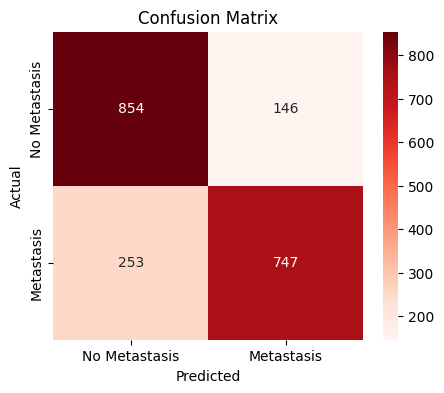

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
def run_final_test(model_path, loader, device):
    # reinitialize the same model architecture
    model = PCamResNet(variant='optimized').to(device)

    # we have to unfreeze the laast layer to keep it consistent with the saved model
    for param in model.backbone.layer4.parameters():
        param.requires_grad = True
    
    # load the model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_targets = []

    print(f"Testing best model: {model_path}...")

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()

            preds = (torch.sigmoid(outputs)>0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
        
    # calculate metrics
    rec = recall_score(all_targets, all_preds)
    acc = accuracy_score(all_targets, all_preds)

    print(f"{'='*10} Final Test Results {'='*10}")
    print(f"Test recall: {rec:.4f}")
    print(f"Test accuracy: {acc:.4f}")
    print("\nClassification report:\n")
    print(classification_report(all_targets, all_preds, target_names = ['No Metastatic Tissue Detected', 'Metastatic Tissue Detected']))

    # confusion matric
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Reds',
        xticklabels=['No Metastasis', 'Metastasis'],
        yticklabels=['No Metastasis', 'Metastasis'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return all_targets, all_preds

# run the test
targets, predictions = run_final_test(model_path='./models/best_final_fine_tuned.pth', loader=test_loader, device=device)

# Conclusions
Based on these results, we can draw some conclusions.
On the independent test set, the fine tunes model achieved an overall accuracy of 80% with a macro-averaged F1-score of 0.80, indicating stable and well-balanced performance across classes.
The model showed higher precision for detecting metastasis (0.84) than recall (0.75), which could suggest that when metastasis is predicted, it is usually correct, but approximately 1 in 4 metastatic regions are missed.
On the other hand, on non-metastatic tissue, we see higher recall (0.85) than precision (0.77), reflecting good specificity.
An important point to raise here is that, from a clinical perspective, this model seems to prioritize precision over sensitivity, limiting false-positives at the expense of some false-negatives. Although sparing patients of unnecessary treatment is essential, false-negatives have much more severe consequences here, since it would mean patients with metastatic spread are not treated.
The results suggest that the model generalizes well and has potential utility, but it would not serve as a standalone tool at this stage. Perhaps it could offer some utility as a decision-support tool.
That being said, it is also worth to point out that given time and resource contraints, the model was trained on a very limited subset of images, and further tuning could also be done. So it is possible that using all of the available data and longer training and tuning could improve performance and yield a model with better specificity at identifying metastatic spread.

# Extracting sample images for testing
As mentioned previously, the dataset is in HDF5 format. In order to give example data for requests, we need to extract a couple of images as regular image format so the dataset doesn't need to be downloaded in its entirety.

In [48]:
from PIL import Image
def save_sample_png(x_path, y_path, indices):
    with h5py.File(x_path, 'r') as f_x, h5py.File(y_path, 'r') as f_y:
        for i, idx in enumerate(indices[:10]):
            label = f_y['y'][idx].flatten()[0]
            img_data = f_x['x'][idx]

            #convert to PIL Image
            img = Image.fromarray(img_data)

            label_name = 'metastatic' if label == 1 else 'non-metastatic'
            filename = f'./data/sample_img/sample_{i}_{label_name}.png'
            img.save(filename)
            print(f"Saved {filename}")

save_sample_png('data/small_test_x.h5', 'data/small_test_y.h5', np.arange(10))

Saved ./data/sample_img/sample_0_non-metastatic.png
Saved ./data/sample_img/sample_1_metastatic.png
Saved ./data/sample_img/sample_2_metastatic.png
Saved ./data/sample_img/sample_3_non-metastatic.png
Saved ./data/sample_img/sample_4_metastatic.png
Saved ./data/sample_img/sample_5_metastatic.png
Saved ./data/sample_img/sample_6_metastatic.png
Saved ./data/sample_img/sample_7_metastatic.png
Saved ./data/sample_img/sample_8_metastatic.png
Saved ./data/sample_img/sample_9_non-metastatic.png
